In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Veri yolları
base_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360'  # Verisetinizin ana dizinini buraya yazın
train_dir = os.path.join(base_dir, 'Training')

# Görüntü boyutu ve batch size
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator ile verileri yükleme
datagen = ImageDataGenerator(rescale=1./255)

# Tüm veri ve etiketleri okuma
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Etiketlerin sırasını korumak için shuffle=False
)

# Veri ve etiketleri toplama
file_paths = train_generator.filepaths
labels = train_generator.classes
class_indices = train_generator.class_indices  # Sınıf isimleri ve etiket eşleştirmesi
num_classes = len(class_indices)

# Stratify kullanarak eğitim ve doğrulama setini ayırma
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Custom DataGenerator
def custom_data_generator(file_paths, labels, batch_size, target_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            batch_images = []
            for path in batch_paths:
                img = load_img(path, target_size=target_size)  # Görüntüyü yükle
                img_array = img_to_array(img) / 255.0  # Ölçekle
                batch_images.append(img_array)
                
            yield np.array(batch_images), to_categorical(batch_labels, num_classes=num_classes)

# Eğitim ve doğrulama generator'ları
train_gen = custom_data_generator(train_paths, train_labels, batch_size, img_size)
val_gen = custom_data_generator(val_paths, val_labels, batch_size, img_size)

# VGG16 modelini yükleme
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# VGG16 katmanlarını dondurma
for layer in vgg16_model.layers:
    layer.trainable = False

# Modeli oluşturma
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Eğitim
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=5
)

# Eğitim tamamlandıktan sonra
print("Özellik çıkarımı tamamlandı.")


Found 70491 images belonging to 141 classes.
Epoch 1/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 349s 189ms/step - accuracy: 0.3511 - loss: 3.7997 - val_accuracy: 0.9249 - val_loss: 1.3026
Epoch 2/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 308s 172ms/step - accuracy: 0.9485 - loss: 0.9896 - val_accuracy: 0.9851 - val_loss: 0.4441
Epoch 3/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 291s 165ms/step - accuracy: 0.9915 - loss: 0.3484 - val_accuracy: 0.9958 - val_loss: 0.1890
Epoch 4/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 290s 164ms/step - accuracy: 0.9975 - loss: 0.1485 - val_accuracy: 0.9983 - val_loss: 0.0908
Epoch 5/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 291s 165ms/step - accuracy: 0.9992 - loss: 0.0705 - val_accuracy: 0.9993 - val_loss: 0.0469
Özellik çıkarımı tamamlandı.


In [9]:
# Fine-tuning için VGG16'nin son katmanlarını açma
conv_base.trainable = True

# İlk birkaç katmanı dondur (örneğin, ilk 15 katman)
for layer in conv_base.layers[:15]:
    layer.trainable = False

# Fine-tuning için modelin yeniden derlenmesi
model.compile(
    optimizer=Adam(learning_rate=1e-6),  # Daha düşük öğrenme oranı
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning eğitimi
fine_tune_history = model.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=5  # Daha az epoch kullanılır
)

# Fine-tuning tamamlandıktan sonra
print("Fine-tuning tamamlandı.")


Epoch 1/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 297s 167ms/step - accuracy: 0.9997 - loss: 0.0398 - val_accuracy: 0.9994 - val_loss: 0.0410
Epoch 2/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 305s 173ms/step - accuracy: 0.9998 - loss: 0.0355 - val_accuracy: 0.9995 - val_loss: 0.0371
Epoch 3/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 306s 173ms/step - accuracy: 0.9999 - loss: 0.0320 - val_accuracy: 0.9996 - val_loss: 0.0337
Epoch 4/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 300s 171ms/step - accuracy: 0.9999 - loss: 0.0291 - val_accuracy: 0.9996 - val_loss: 0.0306
Epoch 5/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 292s 166ms/step - accuracy: 0.9999 - loss: 0.0264 - val_accuracy: 0.9996 - val_loss: 0.0279
Fine-tuning tamamlandı.


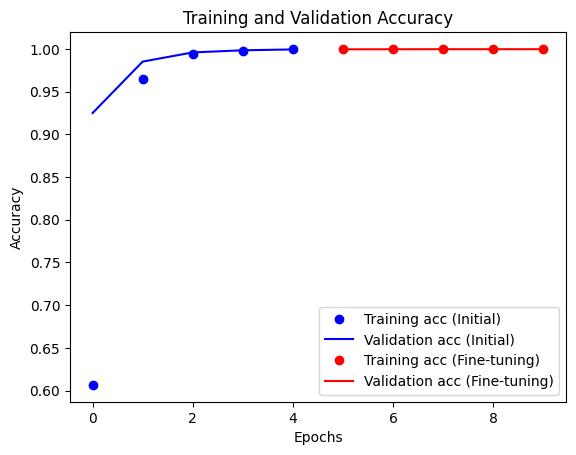

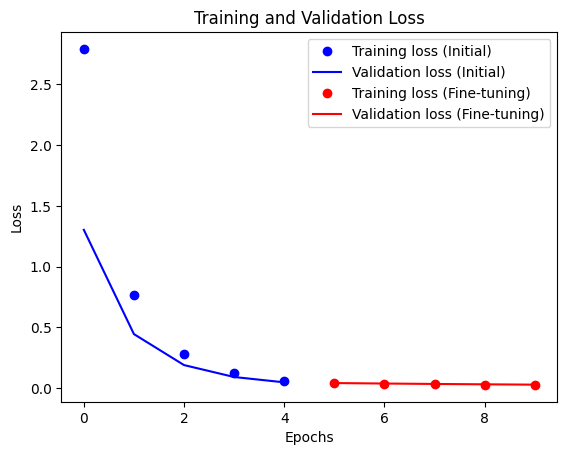

In [10]:
# İlk eğitimden metrikleri al
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Fine-tuning'den metrikleri al
fine_tune_acc = fine_tune_history.history['accuracy']
fine_tune_val_acc = fine_tune_history.history['val_accuracy']
fine_tune_loss = fine_tune_history.history['loss']
fine_tune_val_loss = fine_tune_history.history['val_loss']

# İlk eğitim ve fine-tuning epoch'larını birleştir
epochs_initial = range(len(acc))
epochs_fine_tune = range(len(acc), len(acc) + len(fine_tune_acc))

# Doğruluk grafiği
plt.plot(epochs_initial, acc, 'bo', label='Training acc (Initial)')
plt.plot(epochs_initial, val_acc, 'b', label='Validation acc (Initial)')
plt.plot(epochs_fine_tune, fine_tune_acc, 'ro', label='Training acc (Fine-tuning)')
plt.plot(epochs_fine_tune, fine_tune_val_acc, 'r', label='Validation acc (Fine-tuning)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

# Kayıp grafiği
plt.plot(epochs_initial, loss, 'bo', label='Training loss (Initial)')
plt.plot(epochs_initial, val_loss, 'b', label='Validation loss (Initial)')
plt.plot(epochs_fine_tune, fine_tune_loss, 'ro', label='Training loss (Fine-tuning)')
plt.plot(epochs_fine_tune, fine_tune_val_loss, 'r', label='Validation loss (Fine-tuning)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Found 23619 images belonging to 141 classes.
Test verileri üzerinde tahmin yapılıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


739/739 ━━━━━━━━━━━━━━━━━━━━ 112s 151ms/step

Genel Ortalama Performans Metrikleri:
Accuracy: 0.9564
Precision: 0.9602
Recall: 0.9564
F1 Score: 0.9550

Sınıf Bazlı Performans Metrikleri:
                       precision    recall  f1-score   support

              Apple 6       0.98      1.00      0.99       157
     Apple Braeburn 1       0.98      0.76      0.86       164
 Apple Crimson Snow 1       0.72      0.75      0.73       148
       Apple Golden 1       0.97      1.00      0.98       160
       Apple Golden 2       0.93      0.99      0.96       164
       Apple Golden 3       0.93      0.98      0.95       161
 Apple Granny Smith 1       0.99      0.83      0.90       164
    Apple Pink Lady 1       0.80      0.97      0.88       152
          Apple Red 1       1.00      0.99      1.00       164
          Apple Red 2       0.88      0.99      0.93       164
          Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious 1       1.00      1.00      1.00    

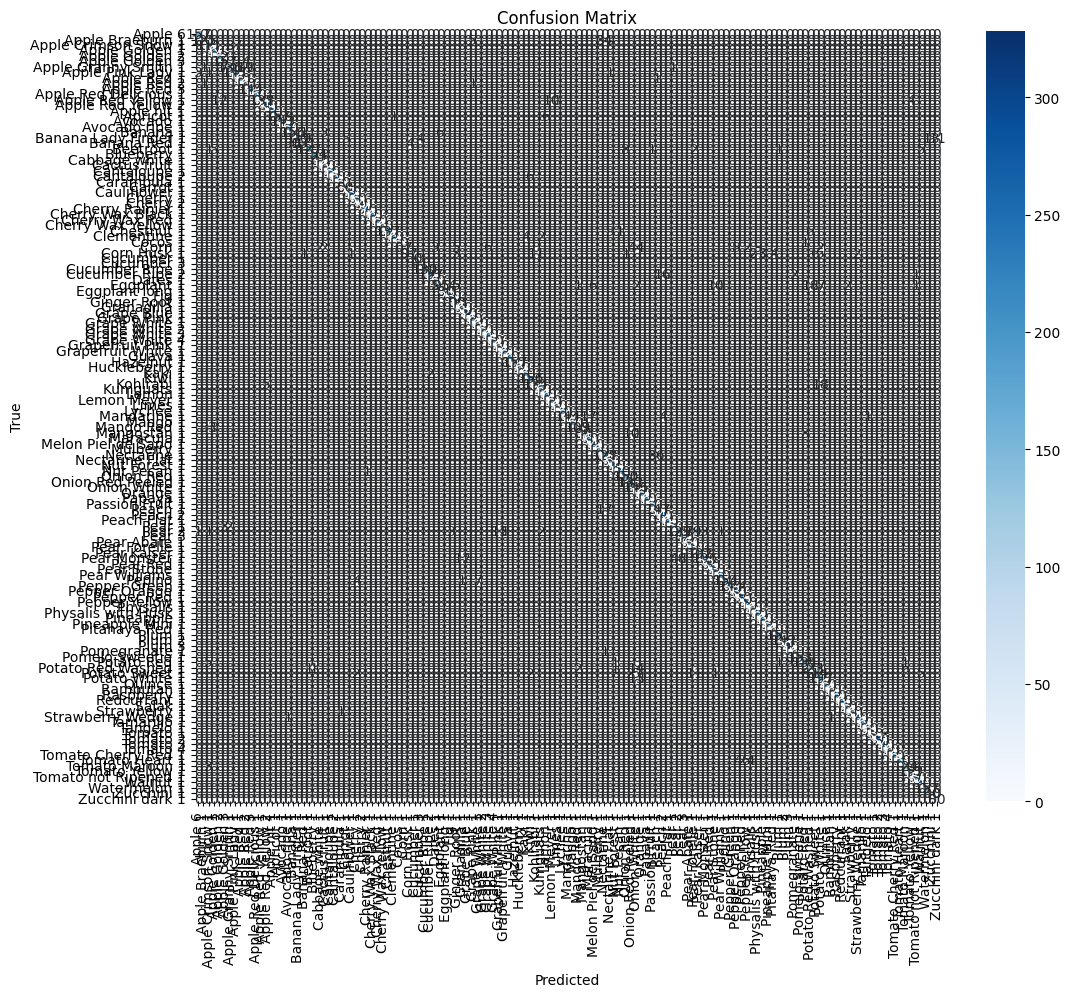

In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Veri yolları
base_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360'  # Verisetinizin ana dizinini buraya yazın

test_dir = os.path.join(base_dir, 'Test')

# Görüntü boyutu ve batch size
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator ile veri hazırlığı
datagen = ImageDataGenerator(rescale=1./255)

# Test setini yükleme
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Etiket sırasını korumak için shuffle=False
)


# Eğitilmiş modeli yüklemek için bir model dosyanız varsa (isteğe bağlı)
# model.load_weights('/path/to/your/saved_model.h5')

# Test seti üzerinde tahmin yapma
print("Test verileri üzerinde tahmin yapılıyor...")
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Tahmin edilen sınıflar ve gerçek sınıflar
predicted_classes = np.argmax(predictions, axis=1)  # Tahmin edilen sınıflar
true_classes = test_generator.classes               # Gerçek sınıflar
class_labels = list(test_generator.class_indices.keys())  # Sınıf isimleri

# Genel metrikler
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("\nGenel Ortalama Performans Metrikleri:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Sınıf bazlı metrikler
print("\nSınıf Bazlı Performans Metrikleri:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nKarışıklık Matrisi:")
print(conf_matrix)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


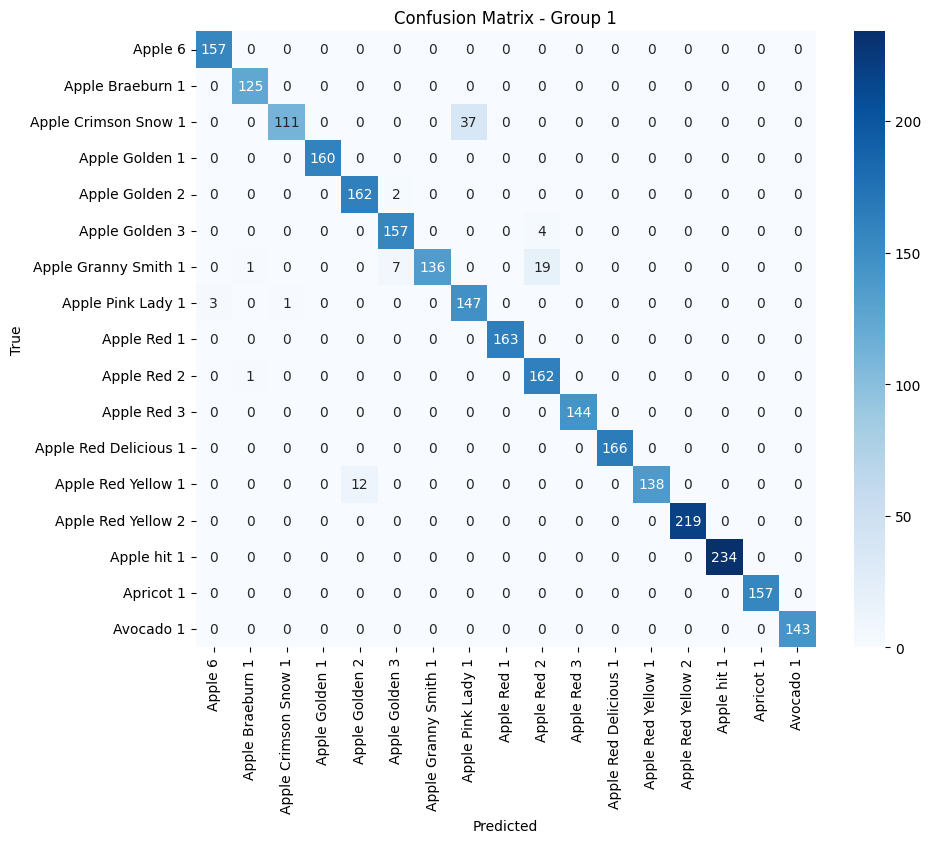

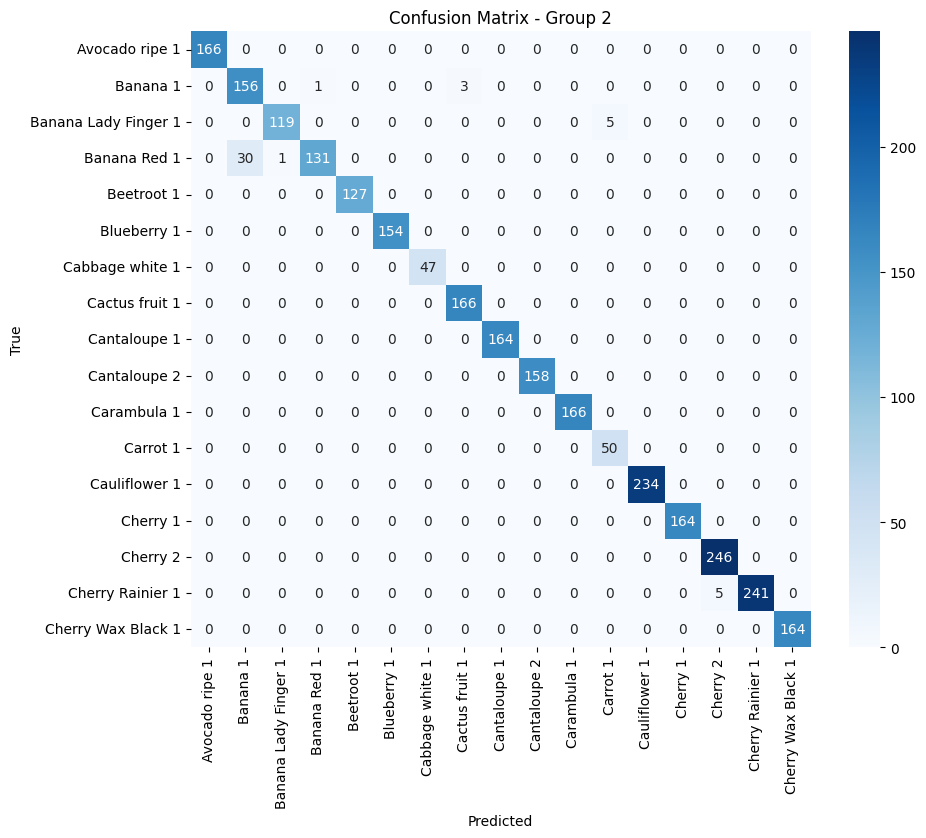

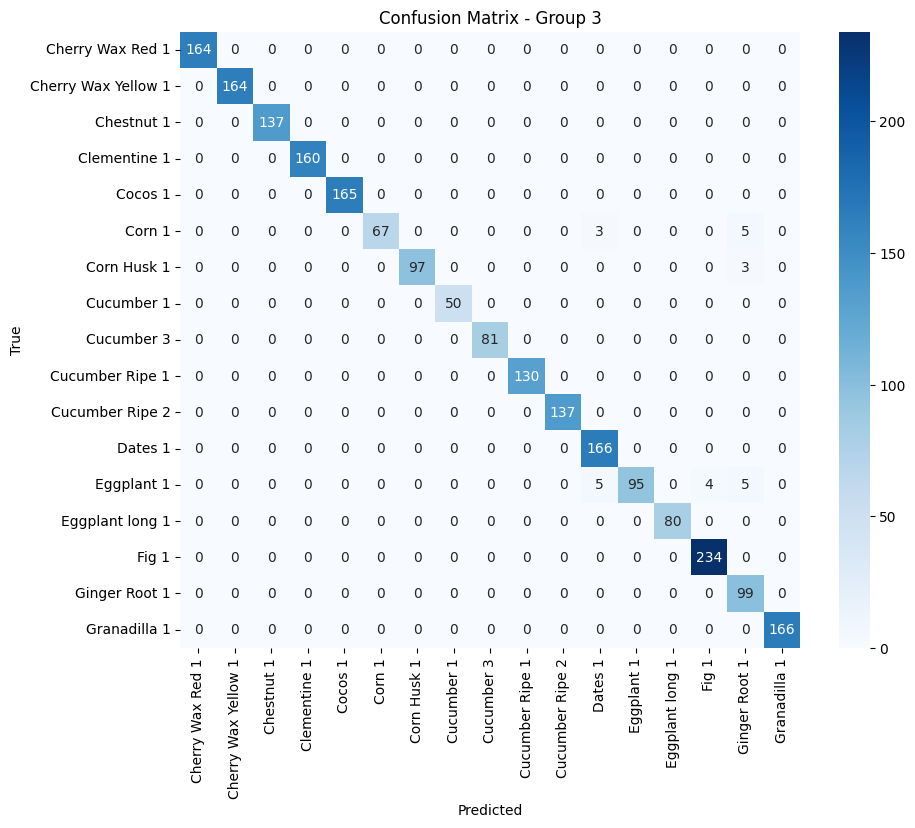

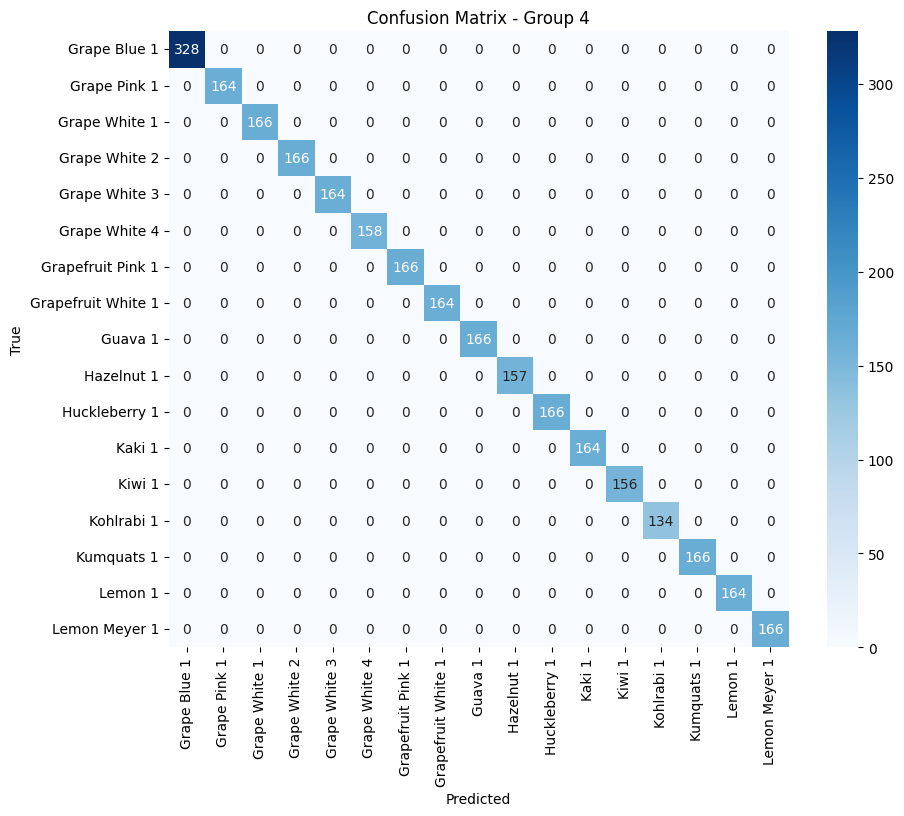

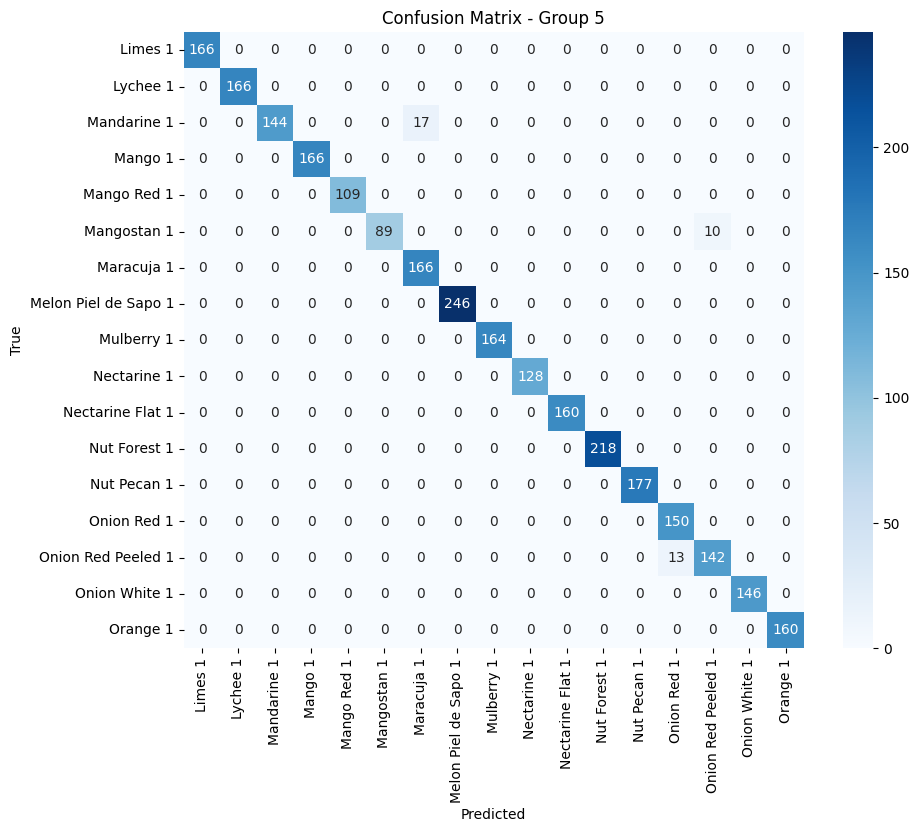

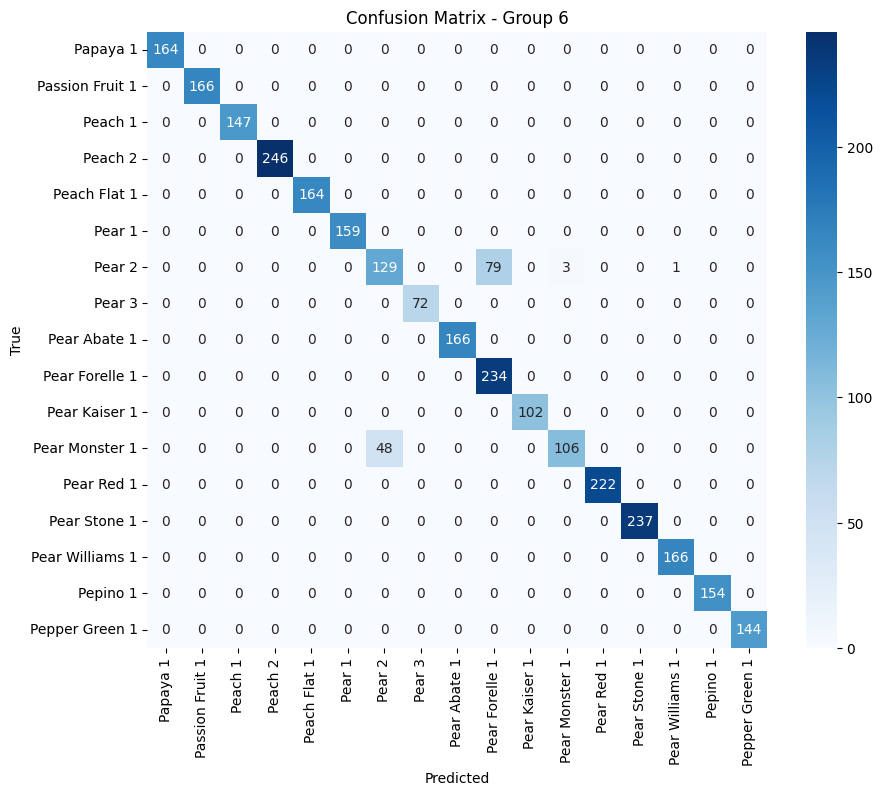

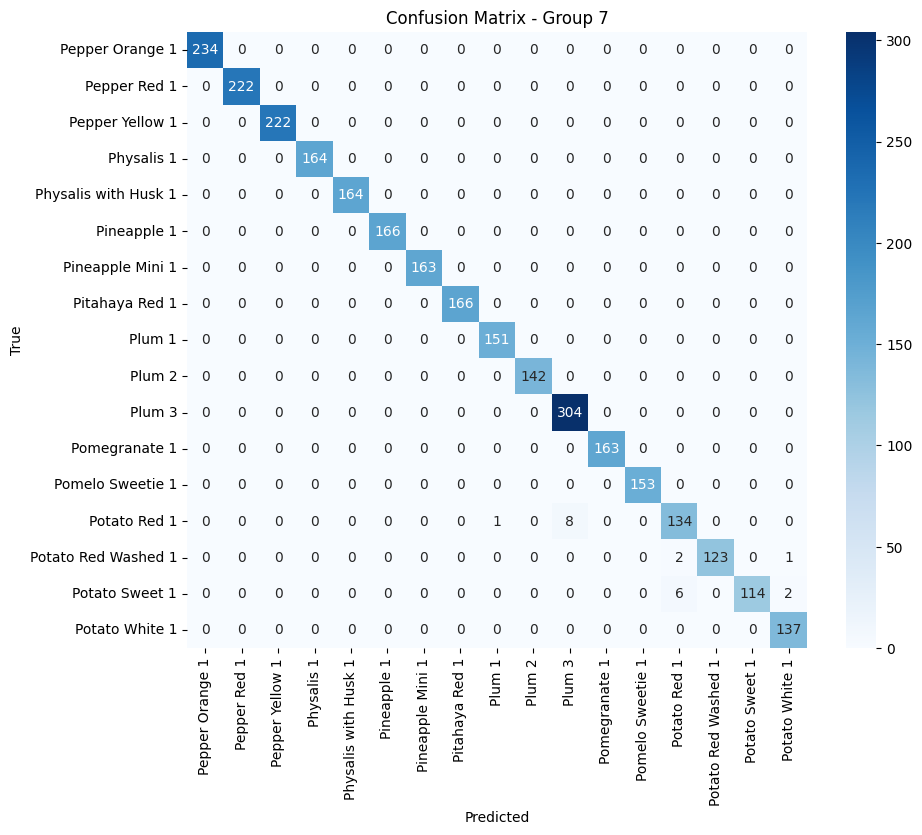

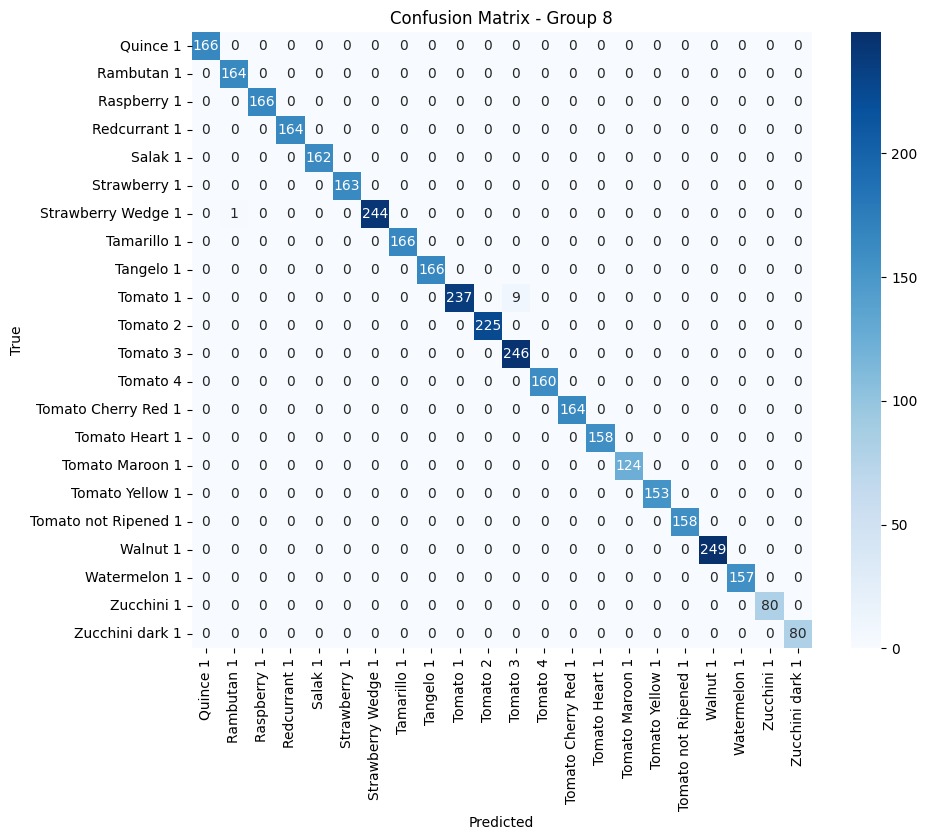

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sınıfları 8 parçaya bölme
num_classes = len(class_labels)  # Toplam sınıf sayısı
num_groups = 8  # Kaç parçaya bölmek istediğimiz
group_size = num_classes // num_groups  # Her grubun boyutu
groups = [class_labels[i * group_size:(i + 1) * group_size] for i in range(num_groups)]

# Eğer sınıflar eşit bölünemiyorsa son gruba kalan sınıfları ekle
if num_classes % num_groups != 0:
    groups[-1].extend(class_labels[num_groups * group_size:])

# Her grup için karışıklık matrisini çizdirme
for i, group_labels in enumerate(groups):
    # Grubun indekslerini bulma
    indices = [class_labels.index(label) for label in group_labels]
    
    # Grubun karışıklık matrisini oluşturma
    group_conf_matrix = conf_matrix[indices][:, indices]
    
    # Matrisi çizdirme
    plt.figure(figsize=(10, 8))
    sns.heatmap(group_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=group_labels, yticklabels=group_labels)
    plt.title(f"Confusion Matrix - Group {i + 1}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
